# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the world’s longest (1949-present) and most complete (more than 50,000 sampling stations) oceanographic and larval fish data time series. The physical, chemical, and biological data collected at regular time and space intervals help document climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern and central California, collecting a suite of hydrographic and biological data on the station and underway. Data collected at depths down to 500 m include temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could predict the temperature of the water based on the salinity and the depth, as well as possibly other available features.

In [1]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn import datasets, decomposition, metrics, preprocessing, utils
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

### Data

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [2]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.6.1


### Utility Functions

In [3]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

#### Data loading

In [4]:
DATA = Path("./data")    # Change to your data folder
assert DATA.exists()

In [5]:
bottle_raw_df = pd.read_csv(DATA / "bottle.csv", low_memory=False)

In [6]:
bottle_info_df = pd.read_csv(
    DATA / "Bottle Field Descriptions.csv",
    encoding="cp1252",
).drop(columns=["Unnamed: 3"])

In [7]:
bottle_info_df[bottle_info_df["Field Name"] == "STheta"]

,Field Name,Units,Description
8,STheta,kilograms per cubic meter,"Potential Density (Sigma Theta), Kg/M³"


In [8]:
bottle_info_df

,Field Name,Units,Description
0,Cst_Cnt,n.a.,"Cast Count - All CalCOFI casts ever conducted,..."
1,Btl_Cnt,n.a.,Bottle Count - All CalCOFI bottles ever sample...
2,Sta_ID,n.a.,Line and Station [Line] [Station]
3,Depth_ID,n.a.,Uses the Cast_ID prefix ([Century]-[Year][Mont...
4,Depthm,meters,Bottle depth in meters
...,...,...,...
57,TA1,micromoles per kilogram,Total Alkalinity micromoles per kilogram solution
58,TA2,micromoles per kilogram,Total Alkalinity micromoles per kilogram solut...
59,pH1,pH scale,pH (the degree of acidity/alkalinity of a solu...
60,pH2,pH scale,pH (the degree of acidity/alkalinity of a solu...


In [9]:
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,1,0,10.500,33.4400,NaN,25.64900
1,1,8,10.460,33.4400,NaN,25.65600
2,1,10,10.460,33.4370,NaN,25.65400
3,1,19,10.450,33.4200,NaN,25.64300
4,1,20,10.450,33.4210,NaN,25.64300
...,...,...,...,...,...,...
864858,34404,0,18.744,33.4083,5.805,23.87055
864859,34404,2,18.744,33.4083,5.805,23.87072
864860,34404,5,18.692,33.4150,5.796,23.88911
864861,34404,10,18.161,33.4062,5.816,24.01426


In [10]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864863 entries, 0 to 864862
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  864863 non-null  int64  
 1   Depthm   864863 non-null  int64  
 2   T_degC   853900 non-null  float64
 3   Salnty   817509 non-null  float64
 4   O2ml_L   696201 non-null  float64
 5   STheta   812174 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 39.6 MB


#### Cleaning

Remove the NaN values

<span style="color:red">Implement your solution below</span>

In [11]:
bottle_df = bottle_df.dropna()

bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 661268 entries, 2160 to 864862
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  661268 non-null  int64  
 1   Depthm   661268 non-null  int64  
 2   T_degC   661268 non-null  float64
 3   Salnty   661268 non-null  float64
 4   O2ml_L   661268 non-null  float64
 5   STheta   661268 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 35.3 MB


### Data Analysis

#### Plot Correlation Matrix with Seaborn

<span style="color:red">Implement your solution below</span>

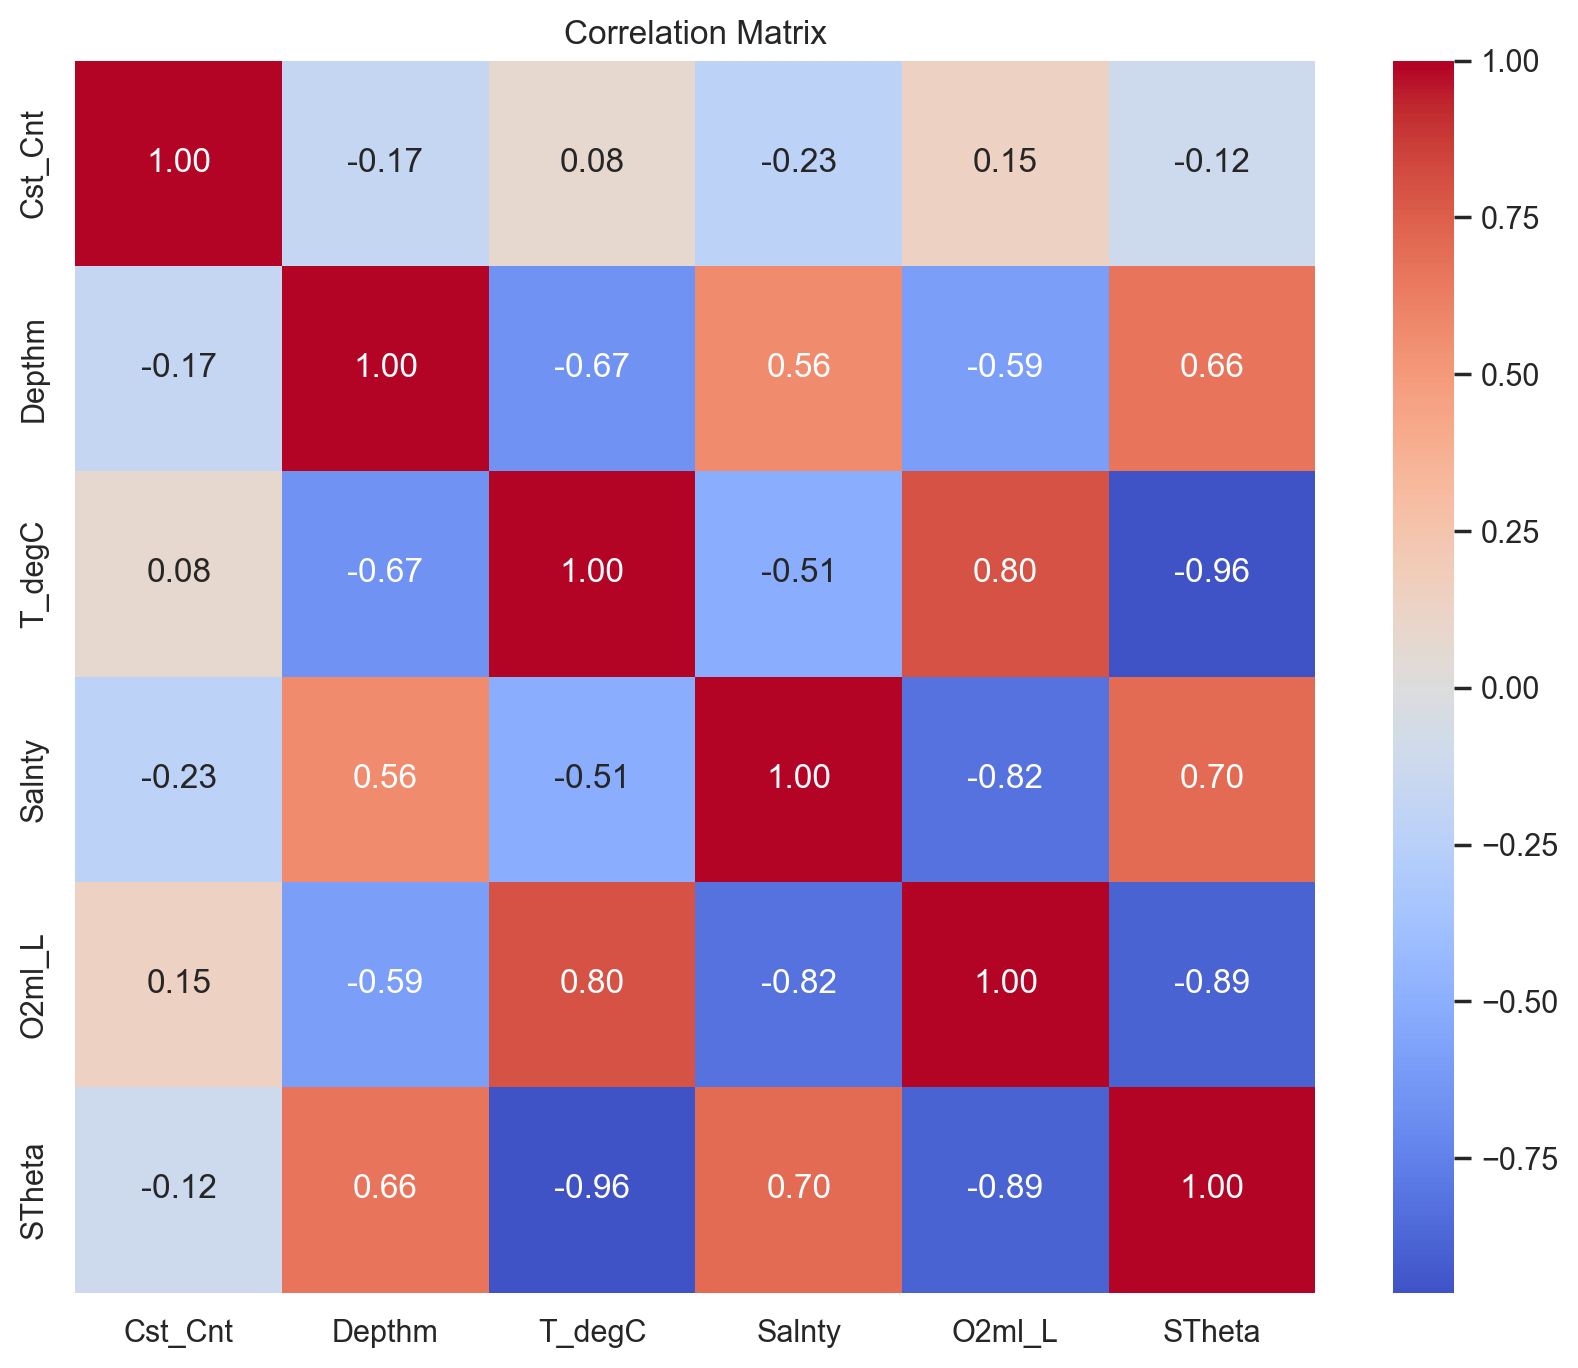

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(bottle_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title("Correlation Matrix")
plt.show()

#### Correlation Plots

Select from the correlation matrix the 4 features involved in the most correlated pairs and plot their relationship.

<span style="color:red">Implement your solution below</span>

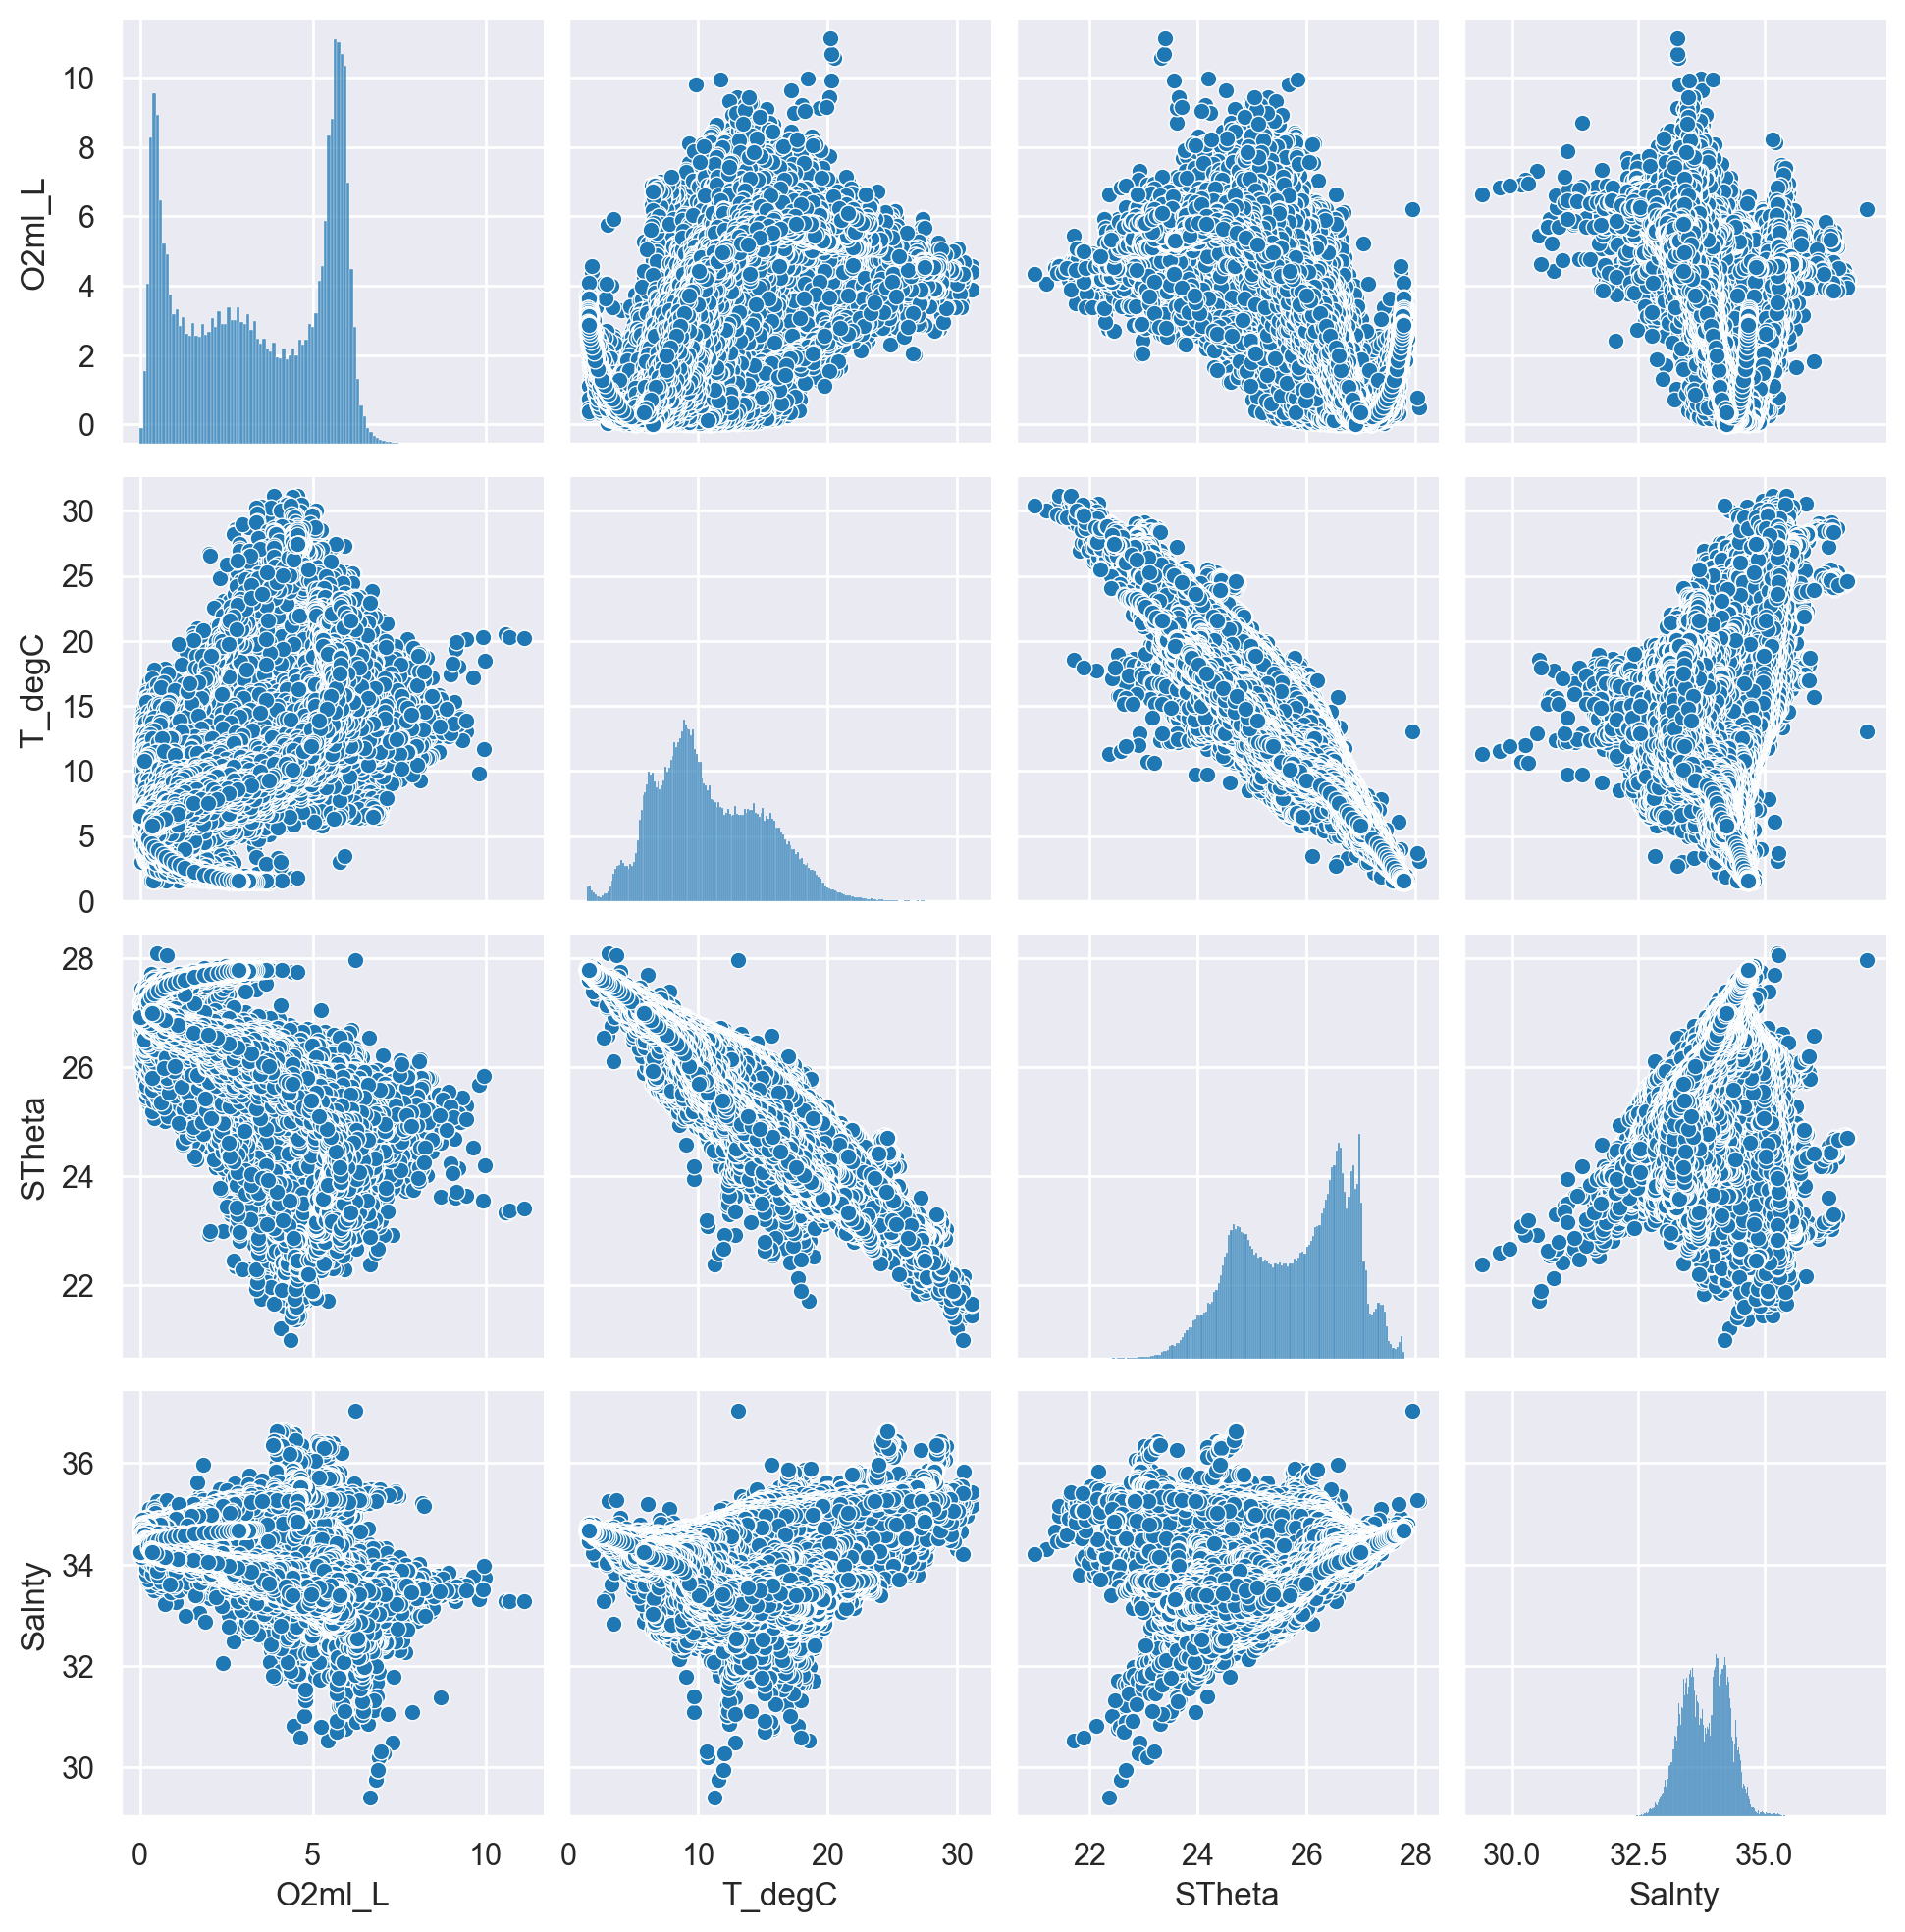

In [13]:

top_features = ['O2ml_L', 'T_degC', 'STheta', 'Salnty']
sns.pairplot(bottle_df[top_features])
plt.suptitle("", y=1.02)
plt.show()

#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

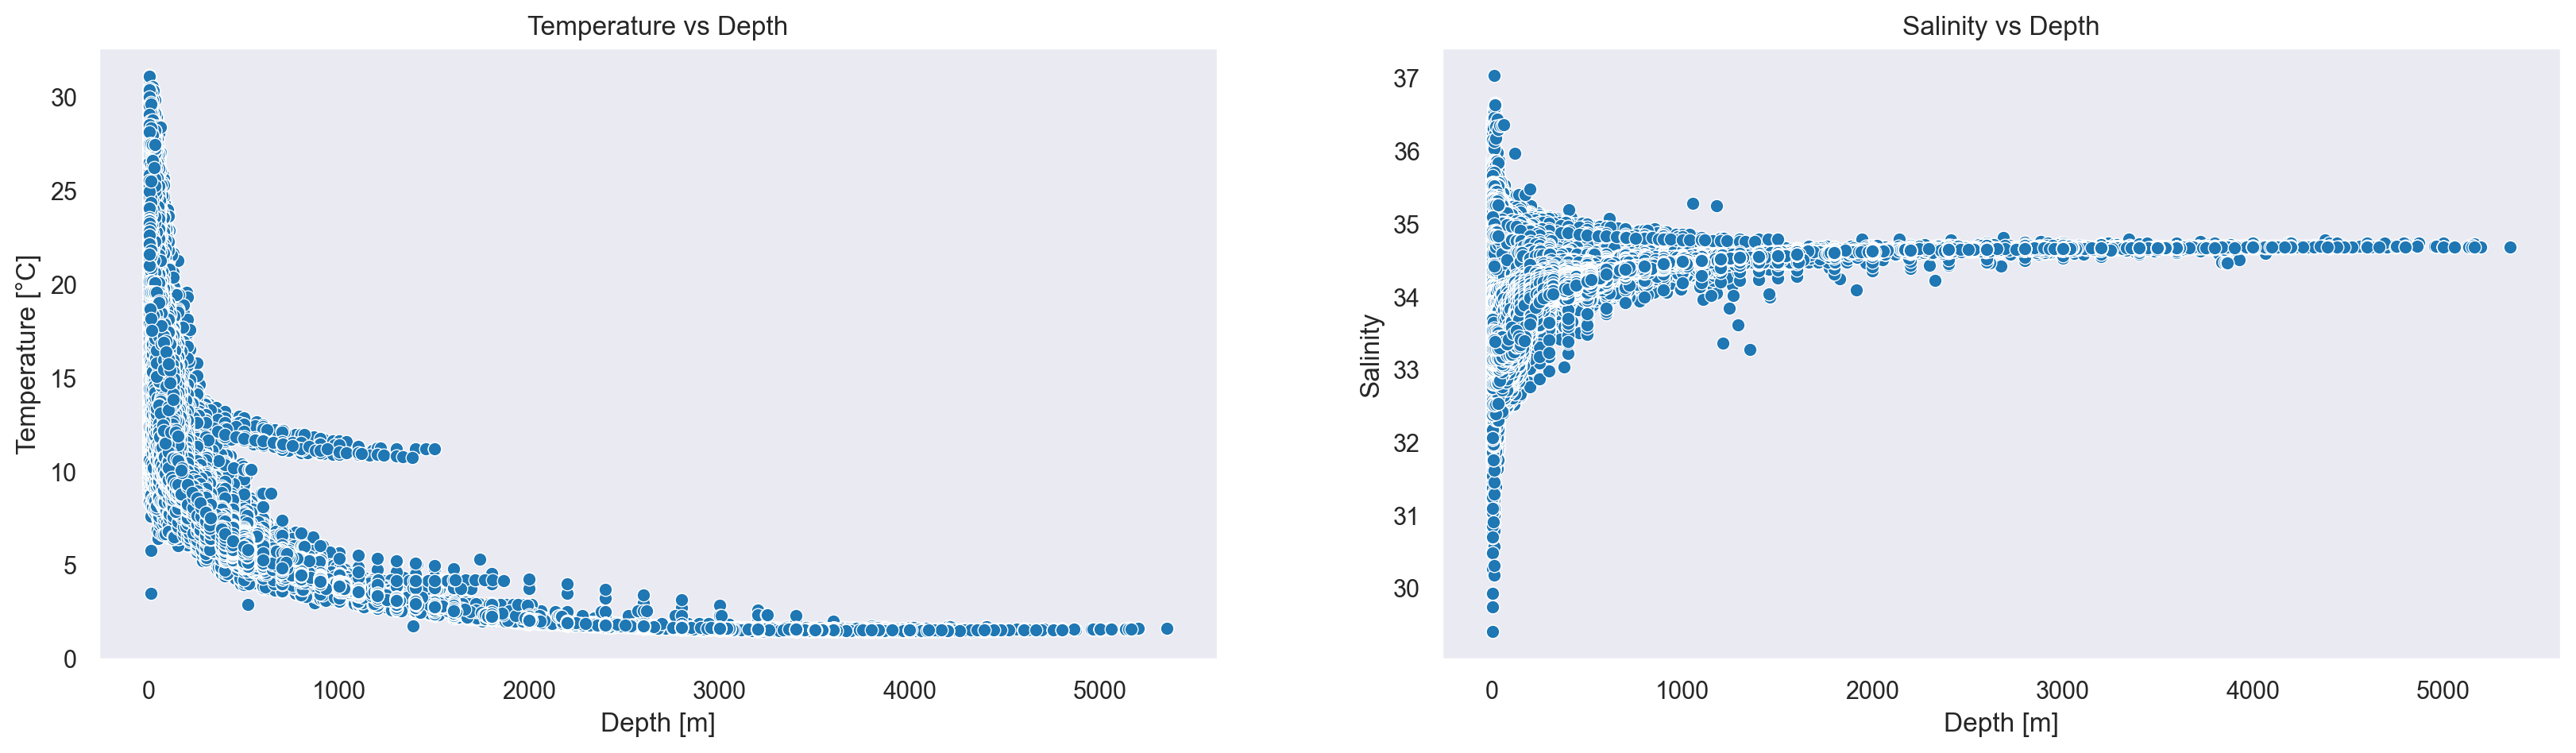

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above, temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot, some points in the upper part of the image show a different trend from the rest of the graph. It is an unexpected behavior because, for instance, at around 1000 m depth, the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html).

- In the second plot, the points converge asymptotically from both high and low salinity values. It means salinity increases with depth in some ocean areas and vice versa.

Suppose we isolate data points with salinity values in the range above the salinity values in the deepest ocean area. In that case, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [15]:
max_depth_salnty = bottle_df.loc[bottle_df.Depthm.idxmax()].Salnty
max_depth_salnty += 0.1  # Margin to stay on the upper side of the asymptote
pprint_var(max_depth_salnty=max_depth_salnty)

bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df   # with max_depth_salnty = 34.85: 6818 rows × 6 columns

max_depth_salnty = 34.78


,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
9204,305,1180,3.10,35.250,0.49,28.083
40328,1303,854,4.01,34.930,1.85,27.736
41497,1339,415,7.80,35.090,0.28,27.381
55857,1809,2142,1.98,34.790,1.85,27.817
55862,1809,2688,1.73,34.810,2.47,27.855
...,...,...,...,...,...,...
479617,19189,11,27.49,34.839,4.62,22.442
479618,19189,20,27.47,34.838,4.59,22.449
479619,19189,30,27.45,34.837,4.55,22.455
479620,19189,31,27.45,34.837,4.55,22.455


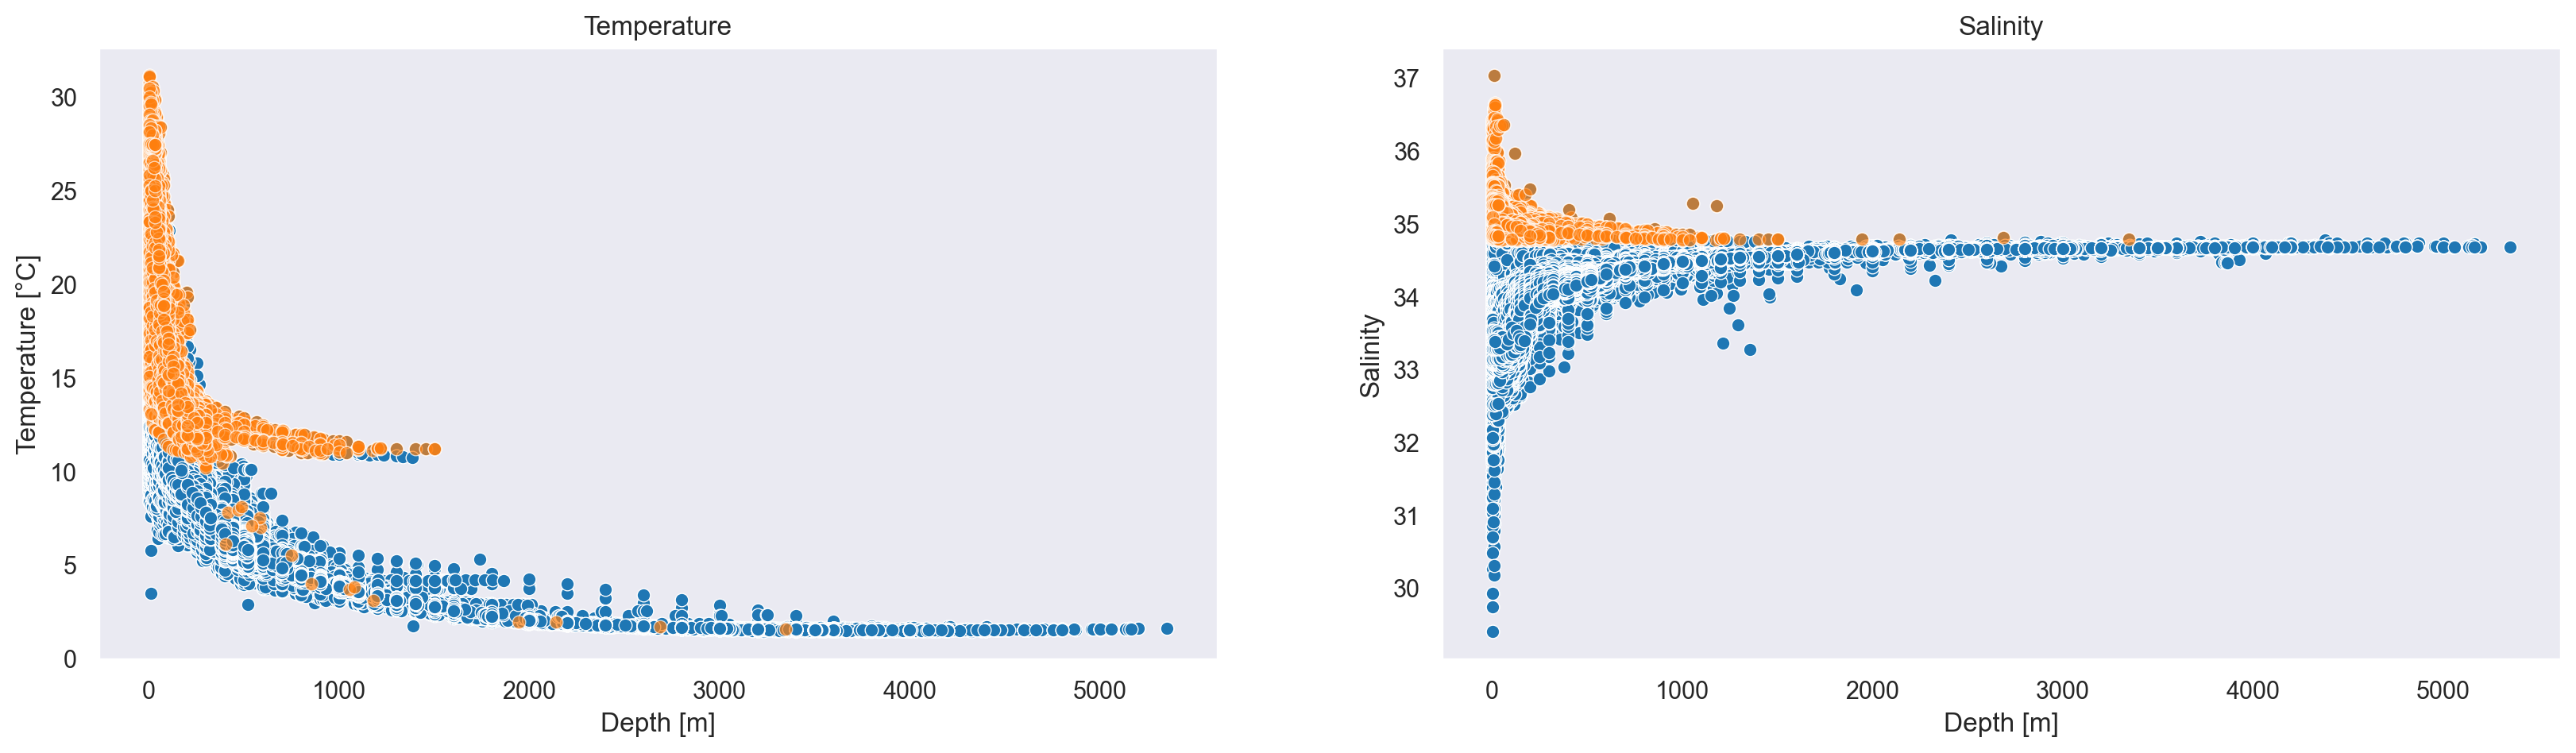

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Splitting the Dataset

<span style="color:red">Implement your solution below</span>

In [17]:

X = bottle_df.drop('T_degC', axis=1)  
y = bottle_df['T_degC']                

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display split information
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set size: 529014 samples
Testing set size: 132254 samples
Number of features: 5


#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

<span style="color:red">Implement your solution below</span>

In [18]:
# data
X_train_depth = X_train[['Depthm']]
X_test_depth = X_test[['Depthm']]

# Create and train the model
model_lr = LinearRegression()
model_lr.fit(X_train_depth, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test_depth)

# Evaluate the model
rmse_lr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr))
r2_lr = metrics.r2_score(y_test, y_pred_lr)

print(f"Linear Regression (Depth only):")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")
print(f"Coefficient: {model_lr.coef_[0]:.6f}")
print(f"Intercept: {model_lr.intercept_:.4f}")

Linear Regression (Depth only):
RMSE: 3.1491
R² Score: 0.4433
Coefficient: -0.009030
Intercept: 12.9012


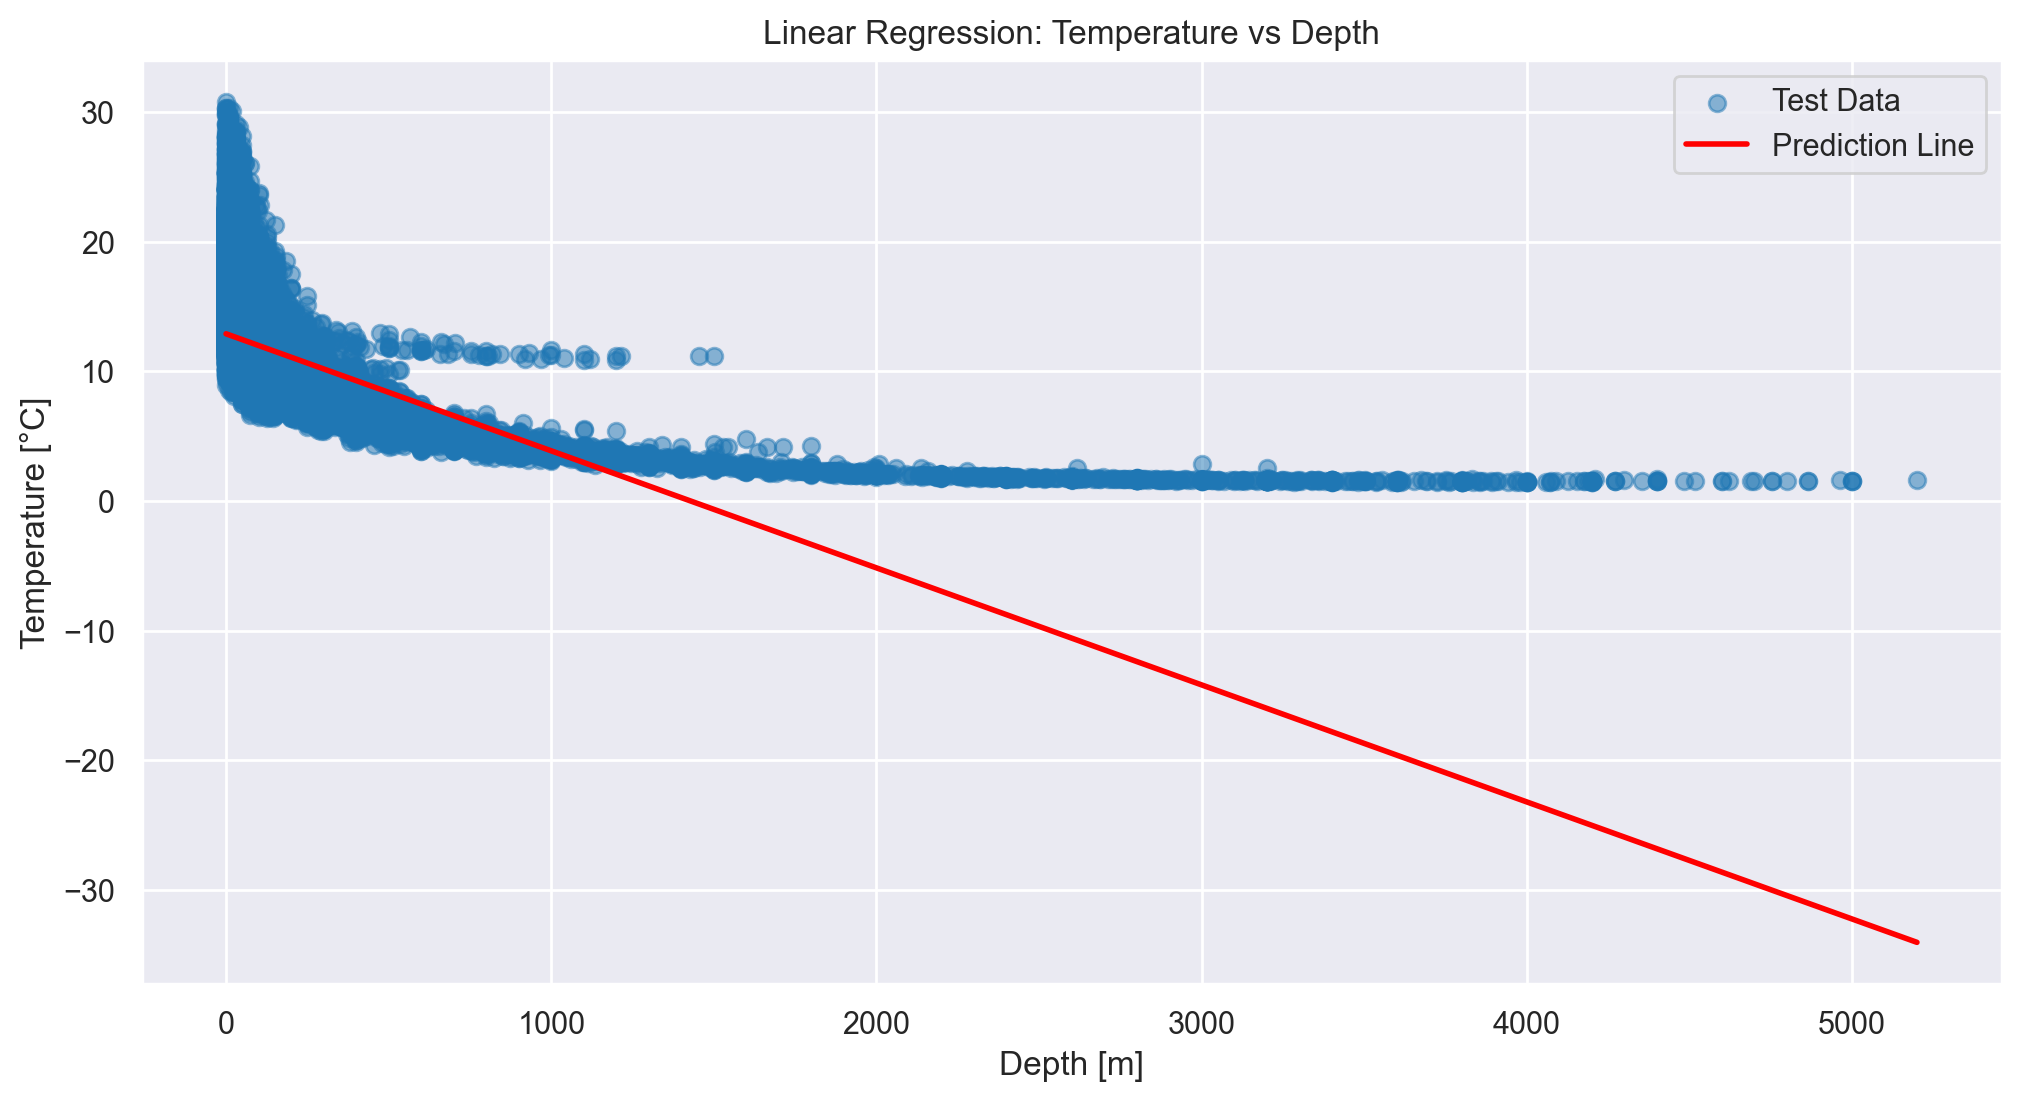

In [19]:
# Plot test data and predicted line
plt.figure(figsize=(12, 6))
plt.scatter(X_test_depth, y_test, alpha=0.5, label='Test Data')

# Sort data for smooth line plotting
sorted_indices = X_test_depth['Depthm'].argsort()
X_sorted = X_test_depth.iloc[sorted_indices]
y_pred_sorted = y_pred_lr[sorted_indices]

plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=2, label='Prediction Line')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title('Linear Regression: Temperature vs Depth')
plt.legend()
plt.grid(True)
plt.show()

### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

<span style="color:red">Implement your solution below</span>

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features transformer
poly = PolynomialFeatures(degree=5)

# Transform training and testing data
X_train_poly = poly.fit_transform(X_train_depth)
X_test_poly = poly.transform(X_test_depth)

# Train linear regression model on polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Make predictions
y_pred_poly = model_poly.predict(X_test_poly)

# Evaluate the model
rmse_poly = np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly))
r2_poly = metrics.r2_score(y_test, y_pred_poly)

print(f"Polynomial Regression (degree=5, Depth only):")
print(f"RMSE: {rmse_poly:.4f}")
print(f"R² Score: {r2_poly:.4f}")

Polynomial Regression (degree=5, Depth only):
RMSE: 3.8524
R² Score: 0.1669


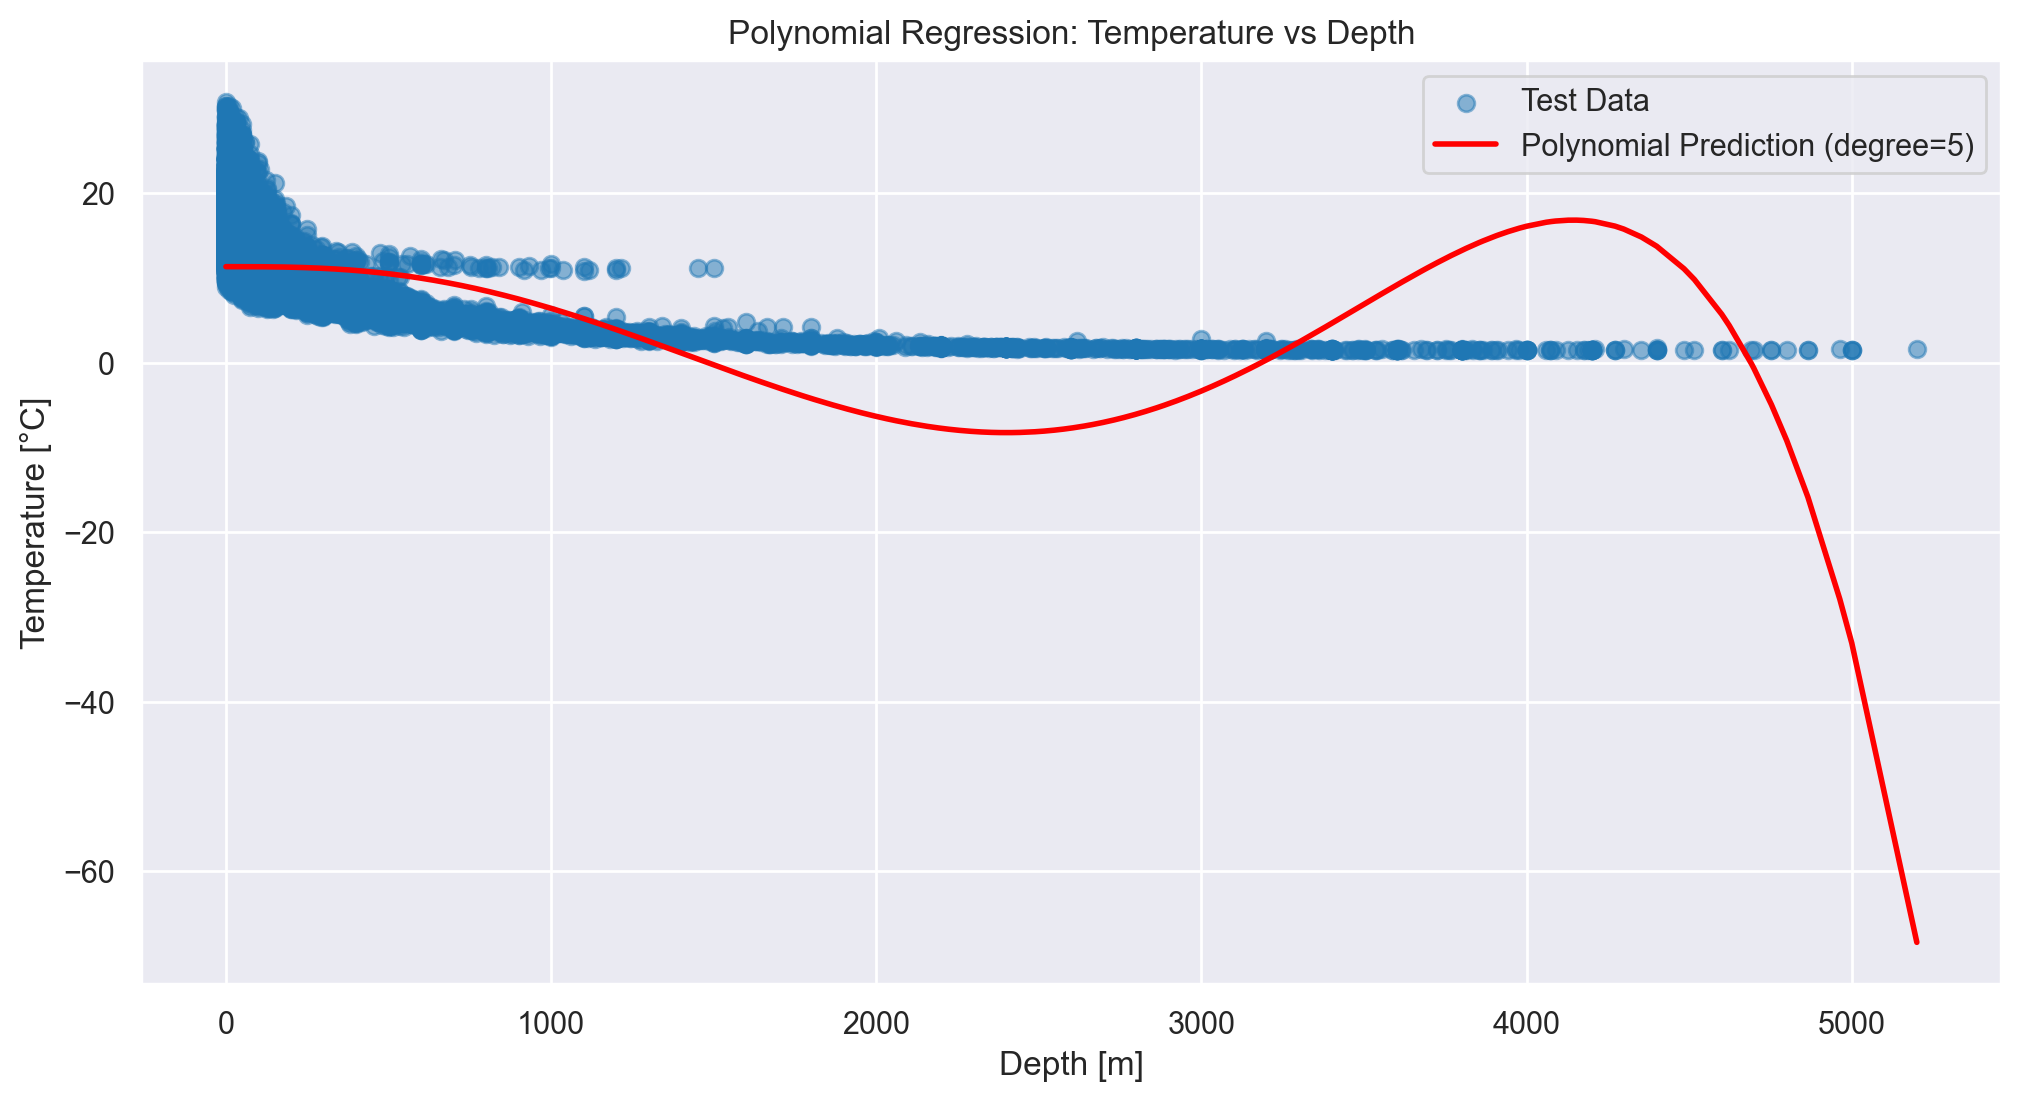

In [21]:
# Plot test data and predicted curve
plt.figure(figsize=(12, 6))
plt.scatter(X_test_depth, y_test, alpha=0.5, label='Test Data')

# Sort data for smooth curve plotting
sorted_indices = X_test_depth['Depthm'].argsort()
X_sorted = X_test_depth.iloc[sorted_indices]
y_pred_sorted = y_pred_poly[sorted_indices]

plt.plot(X_sorted, y_pred_sorted, color='red', linewidth=2, label='Polynomial Prediction (degree=5)')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title('Polynomial Regression: Temperature vs Depth')
plt.legend()
plt.grid(True)
plt.show()

#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

<span style="color:red">Implement your solution below</span>

In [22]:
# Train multiple linear regression using all 5 features
model_mlr = LinearRegression()
model_mlr.fit(X_train, y_train)

# Make predictions
y_pred_mlr = model_mlr.predict(X_test)

# Evaluate the model
mse_mlr = metrics.mean_squared_error(y_test, y_pred_mlr)
r2_mlr = metrics.r2_score(y_test, y_pred_mlr)

print(f"Multiple Linear Regression (All 5 features):")
print(f"MSE: {mse_mlr:.4f}")
print(f"R² Score: {r2_mlr:.4f}")
print(f"\nFeature Coefficients:")
for feature, coef in zip(X_train.columns, model_mlr.coef_):
    print(f"{feature:12s}: {coef:10.6f}")
print(f"{'Intercept':12s}: {model_mlr.intercept_:10.6f}")

# Identify most significant features by absolute coefficient value
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model_mlr.coef_,
    'Abs_Coefficient': np.abs(model_mlr.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nFeature Importance (sorted by absolute coefficient):")
print(feature_importance)

Multiple Linear Regression (All 5 features):
MSE: 0.1109
R² Score: 0.9938

Feature Coefficients:
Cst_Cnt     :   0.000001
Depthm      :  -0.001520
Salnty      :   3.549199
O2ml_L      :   0.146486
STheta      :  -4.589860
Intercept   :   9.056469

Feature Importance (sorted by absolute coefficient):
   Feature  Coefficient  Abs_Coefficient
4   STheta    -4.589860         4.589860
2   Salnty     3.549199         3.549199
3   O2ml_L     0.146486         0.146486
1   Depthm    -0.001520         0.001520
0  Cst_Cnt     0.000001         0.000001


### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment on your observations (possibly with tables and plots similar to those in the PCA notebook).

<span style="color:red">Implement your solution below</span>

In [24]:
# Standardize the features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization completed:")
print(f"Training set mean: {X_train_scaled.mean(axis=0)}")
print(f"Training set std: {X_train_scaled.std(axis=0)}")

Standardization completed:
Training set mean: [-1.62816089e-16 -1.53655837e-17 -4.15085663e-15  6.40465466e-16
  4.82680800e-15]
Training set std: [1. 1. 1. 1. 1.]


In [25]:
# Apply PCA
pca = decomposition.PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Display explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("\nPCA Results:")
print("Explained variance ratio by component:")
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"PC{i+1}: {var:.4f} (Cumulative: {cum_var:.4f})")


PCA Results:
Explained variance ratio by component:
PC1: 0.6360 (Cumulative: 0.6360)
PC2: 0.1925 (Cumulative: 0.8284)
PC3: 0.1000 (Cumulative: 0.9284)
PC4: 0.0565 (Cumulative: 0.9850)
PC5: 0.0150 (Cumulative: 1.0000)


In [26]:
# Regression with all PCA components
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

mse_pca = metrics.mean_squared_error(y_test, y_pred_pca)
r2_pca = metrics.r2_score(y_test, y_pred_pca)

print(f"\nLinear Regression with PCA (All Components):")
print(f"MSE: {mse_pca:.4f}")
print(f"R² Score: {r2_pca:.4f}")

# Compare with Multiple Linear Regression
print(f"\nComparison:")
print(f"Multiple Linear Regression - MSE: {mse_mlr:.4f}, R²: {r2_mlr:.4f}")
print(f"PCA Regression           - MSE: {mse_pca:.4f}, R²: {r2_pca:.4f}")


Linear Regression with PCA (All Components):
MSE: 0.1109
R² Score: 0.9938

Comparison:
Multiple Linear Regression - MSE: 0.1109, R²: 0.9938
PCA Regression           - MSE: 0.1109, R²: 0.9938


In [27]:
# Analyze PCA component loadings (feature contributions to principal components)
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X_train.columns
)

print("\nPCA Component Loadings (Feature Contributions):")
print(components_df)

print("\n\nMost significant features for each component:")
for i in range(pca.n_components_):
    pc_name = f'PC{i+1}'
    top_feature = components_df[pc_name].abs().idxmax()
    print(f"{pc_name}: {top_feature} (loading: {components_df.loc[top_feature, pc_name]:.4f})")


PCA Component Loadings (Feature Contributions):
              PC1       PC2       PC3       PC4       PC5
Cst_Cnt  0.148971  0.980170  0.019396  0.129023  0.007205
Depthm  -0.438443  0.023713  0.866478  0.202740 -0.123765
Salnty  -0.493669 -0.014908 -0.374727  0.722490  0.306035
O2ml_L   0.525604 -0.119444  0.326934  0.209647  0.747419
STheta  -0.515370  0.155615 -0.039163 -0.613438  0.576487


Most significant features for each component:
PC1: O2ml_L (loading: 0.5256)
PC2: Cst_Cnt (loading: 0.9802)
PC3: Depthm (loading: 0.8665)
PC4: Salnty (loading: 0.7225)
PC5: O2ml_L (loading: 0.7474)


**Comments:**

PCA regression achieves the same performance as Multiple Linear Regression (MSE=0.1109, R²=0.9938). The first two principal components explain 82.8% of variance. Feature significance is transformed: in MLR we directly observe feature coefficients, while in PCA features are combined into components (PC1 dominated by O2ml_L, PC2 by Cst_Cnt, PC3 by Depthm). PCA helps with multicollinearity but reduces interpretability.

---